In [4]:
from netCDF4 import Dataset, stringtochar
import numpy as np
import matplotlib.pyplot as plt

In [42]:
def read_nc(path,is_DESC=True):
    file = Dataset(path, mode="r")
    dat = {}
    dat['xm'] = file.variables["xm"][:].filled()
    dat['xn'] = file.variables["xn"][:].filled() / 100
    dat['xm_nyq'] = file.variables["xm_nyq"][:].filled()
    dat['xn_nyq'] = file.variables["xn_nyq"][:].filled() / 100
    dat['NFP']=file.variables["nfp"][:].filled()
    dat['ns']=file.variables["ns"][:].filled()
    dat['rmnc'] = file.variables["rmnc"][:].filled()
    dat['zmns'] = file.variables["zmns"][:].filled()
    
    dat['bsubsmns'] = np.transpose(file.variables["bsubsmns"][:].filled())
    dat['bsubumnc'] = np.transpose(file.variables["bsubumnc"][:].filled())
    dat['bsubvmnc'] = np.transpose(file.variables["bsubvmnc"][:].filled())
    if is_DESC:
        dat['currvmnc'] = file.variables["currvmnc"][:].filled()
    else:
        dat['mnmax_nyq']=file.variables["mnmax_nyq"][:].filled()
        
    dat['s']=file.variables['phi'][:].filled()
    file.close
    return dat
# either add everything you need or use existing DESC stuff, or go to matlab. either way not worth the time this second.
def get_pert_rho(data):
    mn11 = np.where(np.logical_and(data['xm']==1, data['xn'] == 1))[0][0]
    mn31 = np.where(np.logical_and(data['xm']==3, data['xn'] == 1))[0][0]

    drho=0.5*(data['rmnc'][:,mn31]+data['rmnc'][:,mn11]+data['zmns'][:,mn31]-data['zmns'][:,mn11]);
    return drho

In [106]:
## get currumnc and currvmnc
dat['mnyq']=np.max(dat['xm_nyq'])
dat['nnyq']=np.max(dat['xn_nyq'])
# Calculate the Currents
dat['mnmax_nyq']=int(dat['mnmax_nyq'])
dat['ns']=int(dat['ns'])
dat['currumnc']=np.zeros([dat['mnmax_nyq'],dat['ns']])
dat['currvmnc']=np.zeros([dat['mnmax_nyq'],dat['ns']])
ohs = dat['ns']-1
hs  = 1.0/ohs
ns = dat['ns']
shalf=np.zeros([1,ns])
sfull=np.zeros([1,ns])
for i in range(1,ns):#for i=2:ns
    shalf[0,i] = np.sqrt(hs*(i+1-1.5))
    sfull[0,i] = np.sqrt(hs*(i+1-1))

js1 = np.arange(2,ns)#3:ns;
js  = np.arange(1,ns-1)#2:(ns-1);
for mn in range(dat['mnmax_nyq']):#mn = 1:dat['mnmax_nyq']:
    if dat['xm_nyq'][mn]==1:#if (f.xm_nyq,2) == 1
        #t1  = 0.5.*(shalf(js1).*f.bsubsmns(mn,js1)+...
        #    shalf(js).*f.bsubsmns(mn,js))./sfull(js);
        t1  = 0.5*(shalf[0,js1]*dat['bsubsmns'][mn,js1]+shalf[0,js]*dat['bsubsmns'][mn,js])/sfull[0,js]
        
        bu0 =dat['bsubumnc'][mn,js]/shalf[0,js]# f.bsubumnc(mn,js)./shalf(js);
        bu1 = dat['bsubumnc'][mn,js1]/shalf[0,js1]#f.bsubumnc(mn,js1)./shalf(js1);
        #t2  = ohs.*(bu1-bu0).*sfull(js)+0.25.*(bu0+bu1)./sfull(js);
        t2 = ohs * (bu1-bu0)*sfull[0,js] + 0.25 * (bu0+bu1)/sfull[0,js]
        bv0 = dat['bsubvmnc'][mn,js]/shalf[0,js]#f.bsubvmnc(mn,js)./shalf(js);
        bv1 = dat['bsubvmnc'][mn,js1]/shalf[0,js1]#f.bsubvmnc(mn,js1)./shalf(js1);
#         t3  = ohs.*(bv1-bv0).*sfull(js)+0.25.*(bv0+bv1)./sfull(js);
        t3 = ohs * (bv1-bv0)*sfull[0,js] + 0.25*(bv0+bv1)/sfull[0,js]
    else:
#         t1  = 0.5.*(f.bsubsmns(mn,js1)+f.bsubsmns(mn,js));
        t1  = 0.5*(dat['bsubsmns'][mn,js1]+dat['bsubsmns'][mn,js])
        
#         t2  = ohs.*(f.bsubumnc(mn,js1)+f.bsubumnc(mn,js));
        t2  = ohs*(dat['bsubumnc'][mn,js1]+dat['bsubumnc'][mn,js])
                   
#         t3  = ohs.*(f.bsubvmnc(mn,js1)+f.bsubvmnc(mn,js));
        t3  = ohs*(dat['bsubvmnc'][mn,js1]+dat['bsubvmnc'][mn,js])
        
    
    dat['currumnc'][mn,js] =-dat['xn_nyq'][mn]*t1-t3 #-double(f.xn_nyq(mn)).*t1 - t3;
    dat['currvmnc'][mn,js] = -dat['xn_nyq'][mn]*t1+t2#-double(f.xn_nyq(mn)).*t1 + t2;

# % OLD Way
# %for i=2:f.ns-1
# %    f.currumnc(:,i)=-double(f.xnnyq)'.*f.bsubsmns(:,i)-(f.ns-1).*(f.bsubvmnc(:,i+1)-f.bsubvmnc(:,i));
# %    f.currvmnc(:,i)=-double(f.xmnyq)'.*f.bsubsmns(:,i)+(f.ns-1).*(f.bsubumnc(:,i+1)-f.bsubumnc(:,i));
# %end
# f.currumnc(:,1)=0.0;
dat['currumnc'][:,0]=0.0
dat['currvmnc'][:,0]=0.0

# f.currvmnc(:,1)=0.0;
for i in range(dat['mnmax_nyq']):#i=1:f.mnmax_nyq
    if dat['xm_nyq'][i]==0:#(f.xm_nyq(i)==0)
#         f.currumnc(i,1)=2.*f.currumnc(i,2)-f.currumnc(i,3);
        dat['currumnc'][i,1]=2*dat['currumnc'][i,2]-dat['currumnc'][i,3];          
        dat['currvmnc'][i,1]=2*(dat['ns']-1)*dat['bsubumnc'][i,2]

# f.currumnc(:,f.ns)=2.*f.currumnc(:,f.ns-1)-f.currumnc(:,f.ns-2);
dat['currumnc'][:,dat['ns']-1]=2*dat['currumnc'][:,dat['ns']-2]-dat['currumnc'][:,dat['ns']-3]

# f.currvmnc(:,f.ns)=2.*f.currvmnc(:,f.ns-1)-f.currvmnc(:,f.ns-2);
dat['currvmnc'][:,dat['ns']-1]=2*dat['currvmnc'][:,dat['ns']-2]-dat['currvmnc'][:,dat['ns']-3]
mu0 = 4*np.pi * 1e-7
dat['currumnc']=dat['currumnc']/mu0
dat['currvmnc']=dat['currvmnc']/mu0


In [104]:

path='wout_a100_m10n3s1024_q2.0001.nc'
dat = read_nc(path,is_DESC=False)
path='wout_a100_m10n3s064_q2.0001.nc'
dat2 = read_nc(path,is_DESC=False)


In [77]:
print(np.shape(shalf[js1]))


(1022, 1)


In [71]:
print(np.shape(t1))
print(np.shape(dat['xn_nyq'][mn]))

(1022, 1022)
()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# mn11 = np.where(np.logical_and(dat['xm']==1, dat['xn'] == 1))[0][0]
# mn31 = np.where(np.logical_and(dat['xm']==3, dat['xn'] == 1))[0][0]

# drho=0.5*(dat['rmnc'][:,mn31]+dat['rmnc'][:,mn11]+dat['zmns'][:,mn31]-dat['zmns'][:,mn11]);

In [ ]:

# mn11_D = np.where(np.logical_and(dat_D['xm']==1, dat_D['xn'] == 1))[0][0]
# mn31_D = np.where(np.logical_and(dat_D['xm']==3, dat_D['xn'] == 1))[0][0]

# drho_D=0.5*(dat_D['rmnc'][:,mn31_D]+dat_D['rmnc'][:,mn11_D]+dat_D['zmns'][:,mn31_D]-dat_D['zmns'][:,mn11_D]);

In [16]:
np.shape(dat['s'])

(1024,)

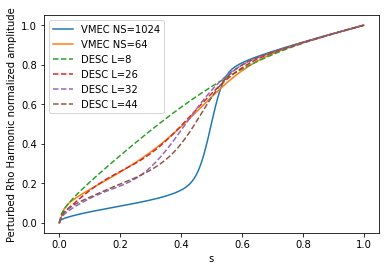

In [21]:
plt.figure()
drho = get_pert_rho(dat)
plt.plot(dat['s']/np.max(dat['s']),drho/np.max(drho),label='VMEC NS=1024')
drho = get_pert_rho(dat2)
plt.plot(dat2['s']/np.max(dat2['s']),drho/np.max(drho),label='VMEC NS=64')

for L in [8,26,32,44]:
    path = f'Cyl_laz_NFP100_M10_N3_L{L}_DESC.nc'
    dat_D = read_nc(path)
    drho_D = get_pert_rho(dat_D)
    plt.plot(dat_D['s']/np.max(dat_D['s']),drho_D/np.max(drho_D),'--',label=f'DESC L={L}')

plt.ylabel('Perturbed Rho Harmonic normalized amplitude')
plt.xlabel('s')
plt.legend()
# save other L's and see how it changes with inc. L

In [ ]:


plt.figure()
drho = get_pert_rho(dat)
plt.plot(dat['s']/np.max(dat['s']),drho/np.max(drho),label='VMEC NS=1024')
for L in [44]:#[8,14,20,26,32,38,44]:
    path = f'Cyl_laz_NFP100_M10_N3_L{L}_DESC.nc'
    dat_D = read_nc(path)
    dex = dat_D['xn_nyq'] == 0
    dat_D['currvmnc'][:,dex]=0
    
    plt.plot(dat_D['s']/np.max(dat_D['s']),dat_D['currvmnc'][:,2:])#,label=f'DESC L={L}')

plt.ylabel('Non-Axisymmetric Current Density Coefficient Amplitude')
plt.xlabel('s')
plt.legend()
# save other L's and see how it changes with inc. L
# not sure if these J are trustworthy tho given prior stuff... only can really trust R,Z
# ... but could use them in matlabVMEC to get this stuff again... but in real space
# maybe set up in python how to calc these from R,Z originally (but won't get axisym, so maybe just copy Sam)
# so it will be using the coeffs basically yea

(-2000.0, 2000.0)

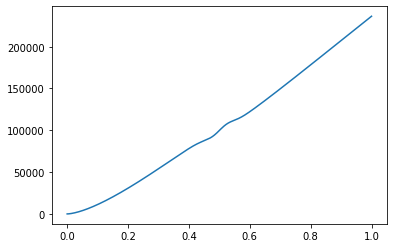

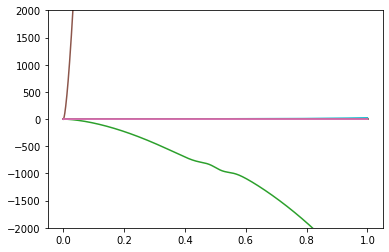

In [107]:
plt.figure()
dex = np.where(np.logical_and(dat['xm_nyq']==2, dat['xn_nyq'] == 1))[0][0]
plt.plot(dat['s']/np.max(dat['s']),dat['currvmnc'][dex,:],label=f'VMEC ns=1024')

plt.figure()
dex = dat['xn_nyq'] == 0
dat['currvmnc'][dex,:]=0
plt.plot(dat['s']/np.max(dat['s']),np.transpose(dat['currvmnc'][:,:]),label=f'VMEC ns=1024');
plt.ylim([-2000,2000])

ValueError: x and y must have same first dimension, but have shapes (128,) and (160,)

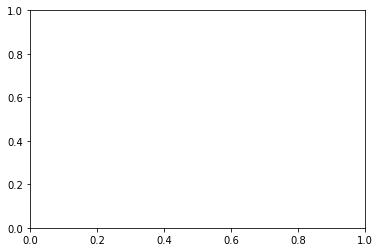

In [92]:
# current non axisymmetric
dex = np.where(np.logical_and(dat['xm_nyq']==2, dat['xn_nyq'] == 1))[0][0]

plt.figure()

plt.plot(dat_D['s']/np.max(dat_D['s']),dat_D['currvmnc'][dex,:],label=f'VMEC ns=1024')
for L in [44]:#[8,14,20,26,32,38,44]:
    path = f'Cyl_laz_NFP100_M10_N3_L{L}_DESC.nc'
    dat_D = read_nc(path)
    dex = np.where(np.logical_and(dat_D['xm_nyq']==2, dat_D['xn_nyq'] == 1))[0][0]
    dat_D['currvmnc'][:,dex]=0
    
    plt.plot(dat_D['s']/np.max(dat_D['s']),dat_D['currvmnc'][:,2:])#,label=f'DESC L={L}')

plt.ylabel('Non-Axisymmetric Current Density Coefficient Amplitude')
plt.xlabel('s')
plt.legend()
# save other L's and see how it changes with inc. L
# not sure if these J are trustworthy tho given prior stuff... only can really trust R,Z
# ... but could use them in matlabVMEC to get this stuff again... but in real space
# maybe set up in python how to calc these from R,Z originally (but won't get axisym, so maybe just copy Sam)
# so it will be using the coeffs basically yea

In [91]:
# mn11 = np.where(np.logical_and(dat['xm_nyq']==1, data['xn_nyq'] == 1))[0][0]
mn21 = np.where(np.logical_and(dat['xm_nyq']==2, data['xn_nyq'] == 1))[0][0]
dex = dat['xn_nyq'] == 0

dat["currumnc"][dex,:]=0
for i in range(len(dat['xn_nyq'])):
    m=dat['xm_nyq'][i]
    n=dat['xn_nyq'][i]
    print(f'ind = {i} m = {m} n = {n} currumnc = {round(dat["currumnc"][-10,i],6)}')

ind = 0 m = 0.0 n = 0.0 currumnc = 0.0
ind = 1 m = 0.0 n = 1.0 currumnc = 1e-06
ind = 2 m = 0.0 n = 2.0 currumnc = -3.2e-05
ind = 3 m = 0.0 n = 3.0 currumnc = -2.9e-05
ind = 4 m = 1.0 n = -3.0 currumnc = -7e-06
ind = 5 m = 1.0 n = -2.0 currumnc = 2e-05
ind = 6 m = 1.0 n = -1.0 currumnc = -9.2e-05
ind = 7 m = 1.0 n = 0.0 currumnc = 0.000166
ind = 8 m = 1.0 n = 1.0 currumnc = 0.000272
ind = 9 m = 1.0 n = 2.0 currumnc = -0.000269
ind = 10 m = 1.0 n = 3.0 currumnc = -7.3e-05
ind = 11 m = 2.0 n = -3.0 currumnc = -8e-05
ind = 12 m = 2.0 n = -2.0 currumnc = -0.00018
ind = 13 m = 2.0 n = -1.0 currumnc = 7.2e-05
ind = 14 m = 2.0 n = 0.0 currumnc = 0.000177
ind = 15 m = 2.0 n = 1.0 currumnc = 0.000179
ind = 16 m = 2.0 n = 2.0 currumnc = -0.000314
ind = 17 m = 2.0 n = 3.0 currumnc = -6.3e-05
ind = 18 m = 3.0 n = -3.0 currumnc = 0.000301
ind = 19 m = 3.0 n = -2.0 currumnc = -0.000363
ind = 20 m = 3.0 n = -1.0 currumnc = -0.000296
ind = 21 m = 3.0 n = 0.0 currumnc = 0.000427
ind = 22 m = 3.0 n = 1.

In [ ]:
# what else? how to compare the nonaxisymmetric current density, which should show a spike? since J parallel does not show it

In [85]:
np.shape(dat['currumnc'])

(67, 1024)